In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
response = requests.get("https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol=BTC&market=EUR&apikey=").json()['Time Series (Digital Currency Daily)']

KeyError: 'Time Series (Digital Currency Daily)'

In [3]:
daily_data = [float(value['4a. close (EUR)']) for value in list(response.values())]

In [4]:
X = np.array(range(len(daily_data))).reshape(-1,1)
Y = np.array(daily_data)

In [5]:
data = pd.read_csv("bitcoin-historical-data\\bitstampUSD_1-min_data_2012-01-01_to_2019-08-12.csv") \
    .drop(['High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price'], axis=1) \
    .fillna(method='ffill')

data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')

data.sort_values(by=['Timestamp'], inplace=True)

data.head()

,Timestamp,Open
0,2011-12-31 07:52:00,4.39
1,2011-12-31 07:53:00,4.39
2,2011-12-31 07:54:00,4.39
3,2011-12-31 07:55:00,4.39
4,2011-12-31 07:56:00,4.39


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000018939D54248>],
      dtype=object)

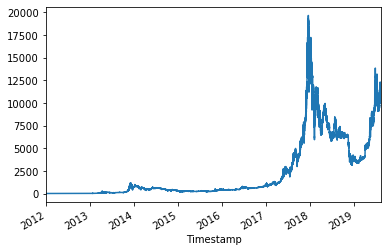

In [6]:
data_to_plot = data['Open']
data_to_plot.index = data['Timestamp']
data_to_plot.plot(subplots=True)

In [7]:
def get_window(dataset, start_index, end_index, window_size, target_size):
  data = []
  labels = []

  start_index = start_index + window_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-window_size, i)
    data.append(np.reshape(dataset[indices], (window_size, 1)))
    labels.append(dataset[i:i+target_size])
  return np.array(data), np.array(labels)

In [8]:
TRAIN_SPLIT = int(len(data) * 0.95)
BATCH_SIZE = 256
BUFFER_SIZE = 10000
STEPS = 200
EPOCHS = 10

In [9]:
tf.random.set_seed(42)

data = data_to_plot.values

data_train_mean = data[:TRAIN_SPLIT].mean()
data_train_std = data[:TRAIN_SPLIT].std()

data = (data - data_train_mean)/data_train_std

window_size = 300
future_target = 60

X, Y = get_window(data, int(TRAIN_SPLIT * 0.65), TRAIN_SPLIT, window_size, future_target)
X_val, Y_val = get_window(data, TRAIN_SPLIT, None, window_size, future_target)                                

train = tf.data.Dataset.from_tensor_slices((X, Y))
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val = val.batch(BATCH_SIZE).repeat()

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=X.shape[1:]))
model.add(tf.keras.layers.LSTM(16, activation='relu'))
model.add(tf.keras.layers.Dense(future_target))

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')

In [10]:
for x, y in val.take(1):
    print(x.shape)
    print(X_val.shape)
    print(model.predict(x).shape)

(256, 300, 1)
(199525, 300, 1)
(256, 60)


In [11]:
model.fit(train, epochs=EPOCHS,
          steps_per_epoch=STEPS,
          validation_data=val, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 207s 1s/step - loss: 0.0982 - val_loss: 0.7955
Epoch 2/10
200/200 [==============================] - 251s 1s/step - loss: 0.0037 - val_loss: 0.7948
Epoch 3/10
200/200 [==============================] - 311s 2s/step - loss: 0.0044 - val_loss: 0.7916
Epoch 4/10
200/200 [==============================] - 409s 2s/step - loss: 0.0039 - val_loss: 0.7897
Epoch 5/10
200/200 [==============================] - 481s 2s/step - loss: 0.0023 - val_loss: 0.7847
Epoch 6/10
200/200 [==============================] - 498s 2s/step - loss: 0.0022 - val_loss: 0.7822
Epoch 7/10
200/200 [==============================] - 434s 2s/step - loss: 0.0037 - val_loss: 0.0777
Epoch 8/10
200/200 [==============================] - 1548s 8s/step - loss: 0.0076 - val_loss: 0.0699
Epoch 9/10
200/200 [==============================] - 498s 2s/step - loss: 0.0044 - val_loss: 0.0535
Epoch 10/10
200/200 [==========================

In [12]:
def show_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))

  history_index = []
  for i in range(-len(history), 0, 1):
    history_index.append(i)

  future_max_index = len(true_future)

  plt.plot(history_index, np.array(history), label='History')
  plt.plot(np.arange(future_max_index), np.array(true_future), 'bo',
           label='True Future')
  plt.plot(np.arange(future_max_index), np.array(prediction), 'ro',
           label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

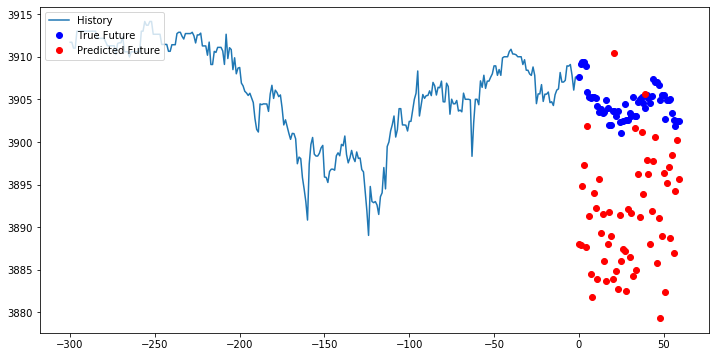

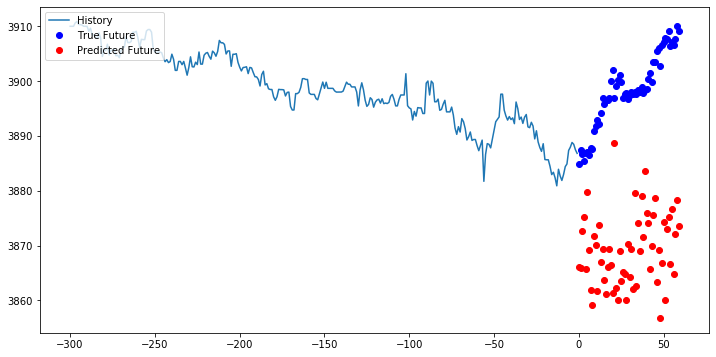

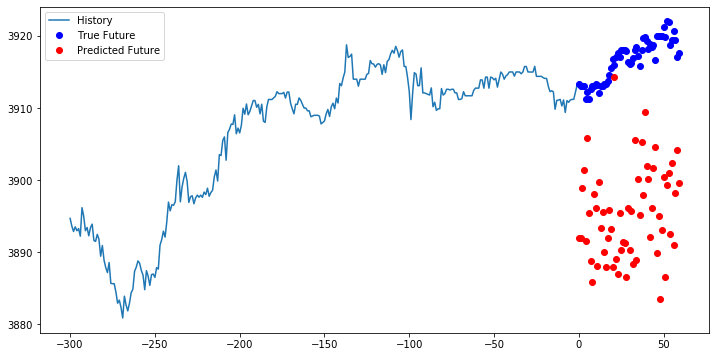

In [13]:
for x, y in val.take(3):
  show_plot((x[0].numpy() * data_train_std) + data_train_mean,
            (y[0].numpy() * data_train_std) + data_train_mean,
            (model.predict(x)[0] * data_train_std) + data_train_mean)